# smol, mash and CMash comparison

(the smol gather experiment)

This experiment compares smol scaled minhash sketches, CMash and mash screen for containment queries.
Experiments were run for ksizes of `21, 31, 51` (except for mash, which only supports `k<=32`).
For mash there is also data for both `num=1000` and `num=100000`.
You can change the numbers below and rerun the notebook to compare results.

There is also an exact version to use as baseline/truth set. It is implemented in Rust, using the `HashSet` in the standard library.

In [1]:
ksize = 31
num = 1000
scaled = 1000

In [349]:
%matplotlib inline
%config InlineBackend.close_figures = False

import numpy as np
import pandas as pd
from IPython.display import Image
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from ficus import FigureManager

pd.options.plotting.backend = "hvplot"

sns.set()
sns.set_palette("tab10")

## Loading data

Loading four dataframes, one for each method plus the exact counts. Harmonize filenames so we can merge the dataframes further down in the analysis.

### smol

`smol` is a minimal implementation of Scaled MinHash and Gather for demonstration purposes. It doesn't include any of the conveniences for working with real biological data like sourmash does, but it's nice for explaining the basic ideas (and both Python and Rust versions are under 250 lines of code, and can interchange sketches since it's a JSON file).

In [3]:
smol = pd.read_table(
    f"../outputs/smol_{scaled}/search-SRR606249-k{ksize}.csv",
    sep=",",
    header=None,
    names=("filename", "smol_c"),
    usecols=("filename", "smol_c"),
)
smol["filename"] = smol["filename"].str.replace(
    r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
)
smol.set_index("filename", inplace=True)

### CMash

#### CMash for published manuscript

In [4]:
cmash_paper = pd.read_table(
    f"../outputs/cmash_paper/SRR606249-k{ksize}-n{num}.csv",
    sep=",",
    header=0,
    names=("filename", "intersection", "cmash paper", "jaccard index"),
    usecols=("filename", "cmash paper"),
)
cmash_paper.columns = ["filename"] + [c for c in cmash_paper.columns[1:]]
cmash_paper["filename"] = cmash_paper["filename"].str.replace(
    r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
)
cmash_paper.set_index("filename", inplace=True)

### mash

`mash screen` outputs the `mash containment` in the first column, and a hashes proportion in the second `(matched hashes / sketch size)`.
I'll be using the proportion, and also harmonizing filename to be able to join dataframes later.

Since `mash sketch` has a cutoff parameter `-m` that can be used to discard k-mers below the cutoff during sketch construction, I tried using `-m 1` and `-m 3` (which is also used in the mash screen paper for the SRA metagenomes comparison) to see if there are differences:

In [5]:
if ksize <= 32:  # mash doesn't support k>32
    mash_mn = pd.read_table(
        f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m3.tsv",
        header=None,
        names=(
            "identity",
            "hashes",
            "median abundance",
            "p-value",
            "filename",
            "description",
        ),
        usecols=["filename", "hashes"],
    )
    mash_mn["filename"] = mash_mn["filename"].str.replace(".*/", "")
    mash_mn["mash_m3"] = mash_mn["hashes"].apply(lambda x: eval(x))
    del mash_mn["hashes"]
    mash_mn.set_index("filename", inplace=True)

In [6]:
if ksize <= 32:  # mash doesn't support k>32
    mash_m1 = pd.read_table(
        f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m1.tsv",
        header=None,
        names=(
            "identity",
            "hashes",
            "median abundance",
            "p-value",
            "filename",
            "description",
        ),
        usecols=["filename", "hashes"],
    )
    mash_m1["filename"] = mash_m1["filename"].str.replace(".*/", "")
    mash_m1["mash_m1"] = mash_m1["hashes"].apply(lambda x: eval(x))
    del mash_m1["hashes"]
    mash_m1.set_index("filename", inplace=True)

If we plot a histogram of the differences we see that the results mostly agree, but in a few cases it is quite far (which makes sense, for low coverage genomes `-m 3` is pretty strict).
Using `-m 1` from now on (which also matches the default sourmash and CMash behavior).

In [7]:
if ksize <= 32:  # mash doesn't support k>32
    with pd.option_context("display.max_rows", None):
        display(
            (mash_m1["mash_m1"] - mash_mn["mash_m3"]).abs().sort_values().hvplot.hist()
        )

:Histogram   [0]   (0_count)

### Exact

The exact code uses the Rust `HashSet` from the standard library to keep all k-mers in the query metagenome, as well as each of the reference genomes, storing it on disk for later comparisons. It uses [needletail]() for FASTA/Q parsing, keep the canonical k-mer (smaller between k-mer and reverse complement), and its sequence normalization method (described in the [docs](https://docs.rs/needletail/0.3.2/needletail/sequence/fn.normalize.html), copied here for easier reference):
```
Transform a nucleic acid sequence into its "normalized" form.

The normalized form is:

    only AGCTN and possibly - (for gaps)
    strip out any whitespace or line endings
    lowercase versions of these are uppercased
    U is converted to T (make everything a DNA sequence)
    some other punctuation is converted to gaps
    IUPAC bases may be converted to N's depending on the parameter passed in
    everything else is considered a N
```

All tools agree with this normalization process:

- sourmash and smol: converts all bases to uppercase, skips k-mers with N (or any non-ACGT bases), keep canonical
- cmash: same as sourmash
  * ref https://github.com/dkoslicki/CMash/blob/db7da08cd897edabfccbbe7bd252572799737c5e/CMash/MinHash.py#L166
- mash: uppercase (unless `-Z` is set), skip bad k-mers (not in alphabet), keep canonical (unless `-n` is set)
  * ref https://github.com/marbl/Mash/blob/a1afacd0ef3f503ba0133a1b8bb57b79b795dfe7/src/mash/Sketch.cpp#L509
  
(another discussion about sequence cleanup in `khmer`: https://github.com/dib-lab/khmer/pull/1590)

In [8]:
exact = pd.read_table(
    f"../outputs/exact/SRR606249-k{ksize}.csv",
    sep=",",
    header=None,
    names=("filename", "exact", "intersection", "|A|"),
    usecols=("filename", "exact"),
)
exact["filename"] = exact["filename"].str.replace(
    r".*/(?P<id>\d+)-k\d+.set", lambda m: m.group("id") + ".fa"
)
exact.set_index("filename", inplace=True)

### sourmash

`sourmash_c` uses `sourmash search --containment` to report containment (above a threshold) for every dataset in a collection.

In [9]:
sourmash_c = pd.read_table(
    f"../outputs/scaled_{scaled}/containments_SRR606249-k{ksize}.csv",
    sep=",",
    usecols=["containment", "filename"],
)
sourmash_c.columns = ("sourmash_c", "filename")
sourmash_c.set_index("filename", inplace=True)

In [10]:
sourmash_g = pd.read_table(
    f"../outputs/scaled_{scaled}/SRR606249-k{ksize}.csv",
    sep=",",
    usecols=["filename", "f_match_orig"],
)
sourmash_g.columns = ("filename", "sourmash_g")
sourmash_g["filename"] = sourmash_g["filename"].str.replace(
    r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa"
)
sourmash_g.set_index("filename", inplace=True)

In [11]:
sourmash_diff = np.abs(sourmash_c["sourmash_c"] - sourmash_g["sourmash_g"])
sourmash_diff[sourmash_diff > 0.01].sort_values()

Series([], dtype: float64)

In [12]:
#sourmash_c = sourmash_g

## Containment checks

Merging the three dataframes, and since the `containment` for each method is in a column with the method name, it is easy to get the proper labels for plotting later.

In [13]:
# all_methods = pd.concat((exact, smol, cmash, cmash_all, cmash_paper, mash_m1, mash_mn, sourmash_c, sourmash_g), axis=1)
if ksize > 31:  # mash doesn't support k>32
    #all_methods = pd.concat((exact, smol, cmash_paper, sourmash_c), axis=1)
    all_methods = pd.concat((exact, smol, cmash_paper), axis=1)
else:
    #all_methods = pd.concat((exact, smol, cmash_paper, mash_m1, sourmash_c), axis=1,)
    all_methods = pd.concat((exact, smol, cmash_paper, mash_m1), axis=1,)    

In [14]:
all_methods.sort_values(by="exact").hvplot(height=400, width=1000, xaxis="top", rot=45)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

mash containment is always above .95, but it is hard to visualize what is happening in this graph. Let's try to use a table, and filter out results where they agree (where "agree" is at most an 1% difference in containment):

In [15]:
def highlight_diff_from_exact(s):
    diff = np.abs(s - s["exact"])
    colorized = []
    for v in diff:
        if v < 0.001:
            colorized.append("background-color: white")
        elif v < 0.01:
            colorized.append("background-color: yellow")
        elif v < 0.05:
            colorized.append("background-color: orange")
        else:
            colorized.append("background-color: red")
    return colorized


with pd.option_context("display.max_rows", None, "show_dimensions", True):
    df = all_methods.sort_values(by="smol_c")
    df = df[df.apply(lambda x: any(np.abs(x - x["exact"]) > 0.01), axis=1)]
    display(df.style.apply(highlight_diff_from_exact, axis=1))

,exact,smol_c,cmash paper,mash_m1
20.fa,0.130274,0.124593,0.118000,0.115000
66.fa,0.129910,0.125850,0.107000,0.111000
67.fa,0.125511,0.136255,0.129000,0.143000
55.fa,0.742809,0.743673,0.714000,0.761000
17.fa,0.764205,0.769295,0.737000,0.781000
7.fa,0.906082,0.905975,0.896000,0.908000
58.fa,0.941358,0.941068,0.929000,0.946000
63.fa,0.949138,0.949217,0.936000,0.948000
16.fa,0.968415,0.961267,0.960000,0.957000
46.fa,0.977215,0.976872,0.962000,0.972000


In [16]:
all_methods.apply(lambda s: s - s["exact"], axis=1).hvplot.box(height=600)

:BoxWhisker   [Variable]   (value)

In [17]:
all_methods

,exact,smol_c,cmash paper,mash_m1
0.fa,0.999972,0.999760,0.990,1.000
1.fa,0.999626,0.998647,0.990,0.999
2.fa,0.999800,1.000000,0.990,1.000
3.fa,0.998586,0.998133,0.988,0.999
4.fa,0.998083,0.997446,0.989,0.997
...,...,...,...,...
63.fa,0.949138,0.949217,0.936,0.948
64.fa,0.018883,0.017807,0.024,0.019
65.fa,0.009827,0.008466,0.013,0.006
66.fa,0.129910,0.125850,0.107,0.111


In [18]:
# low coverage genomes
low_coverage = (
    # From Awad 2018
    27,  # Leptothrix cholodnii
    23,  # Haloferax volcanii DS2
    46,  # Salinispora tropica
    16,  # Deinococcus radiodurans
    58,  # Zymomonas mobilis
    44,  # Ruegeria pomeroyi
    63,  # Shewanella baltica OS223
    6,  # B. bronchiseptica D989
    7,  # Burkholderia xenovorans
    17,  # Desulfovibrio vulgaris DP4
    55,  # Thermus thermophilus HB27
    19,  # Enterococcus faecalis
    20,  # Fusobacterium nucleatum ATCC 25586
    # From mash screen paper
    67,  # Streptococcus parasanguinis strain C1A
)

with pd.option_context("display.max_rows", None, "show_dimensions", True):
    df = all_methods.sort_values(by="smol_c").drop([f"{i}.fa" for i in low_coverage])
    df = df[df.apply(lambda x: any(np.abs(x - x["exact"]) > 0.01), axis=1)]
    display(df.style.apply(highlight_diff_from_exact, axis=1))

,exact,smol_c,cmash paper,mash_m1
66.fa,0.129910,0.125850,0.107000,0.111000
47.fa,0.974065,0.977400,0.964000,0.979000
41.fa,0.996367,0.995664,0.986000,0.996000
9.fa,0.998579,0.997845,0.988000,1.000000
3.fa,0.998586,0.998133,0.988000,0.999000
50.fa,0.999377,0.999095,0.988000,1.000000
38.fa,0.997362,0.999111,0.987000,0.999000
26.fa,0.998290,0.999221,0.988000,0.999000
25.fa,0.998933,0.999374,0.987000,0.999000
42.fa,0.999512,0.999428,0.989000,1.000000


In [19]:
df.apply(lambda s: s - s["exact"], axis=1).hvplot.box(height=600)

:BoxWhisker   [Variable]   (value)

## Similarity and Containment matrices

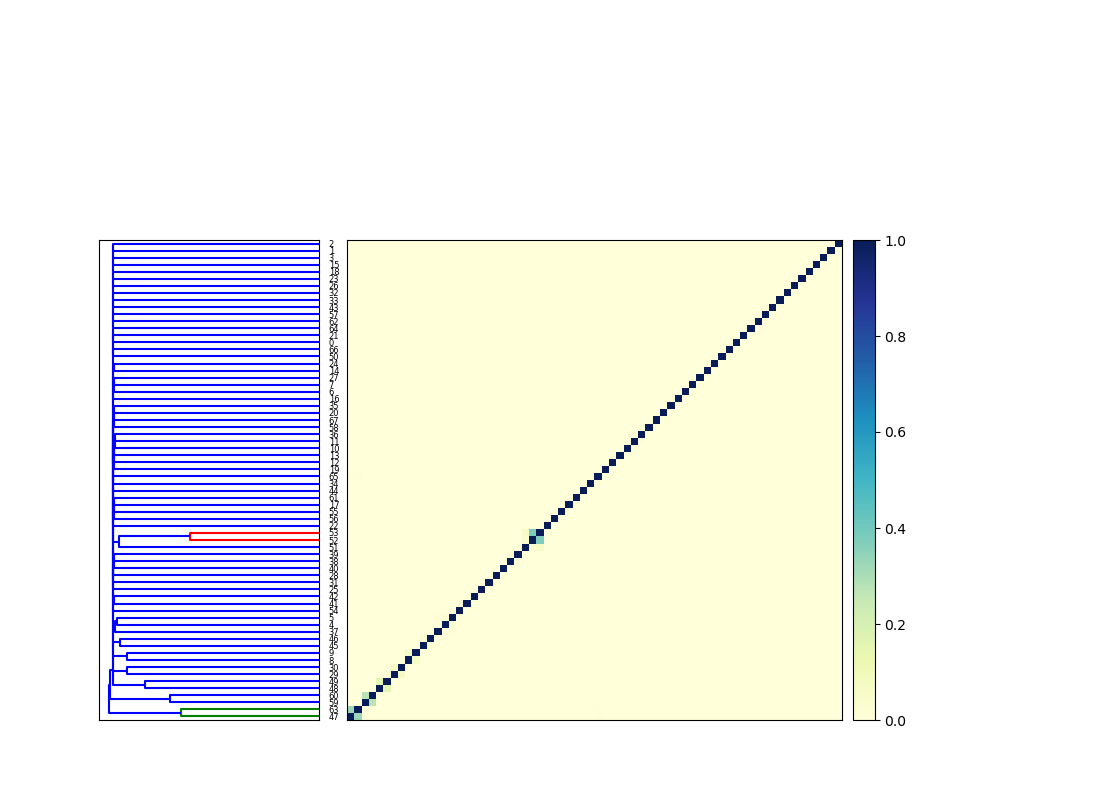

In [20]:
Image(f"../outputs/scaled_1000/similarity-k{ksize}.matrix.png")

**TODO**: containment matrix

## All-in-one figure

In [122]:
def difference_from_exact():
    all_methods = {}
    for k in (21, 31, 51):
        exact = pd.read_table(
            f"../outputs/exact/SRR606249-k{k}.csv",
            sep=",",
            header=None,
            names=("filename", "containment", "intersection", "|A|"),
            usecols=("filename", "containment"),
        )
        exact["filename"] = exact["filename"].str.replace(
            r".*/(?P<id>\d+)-k\d+.set", lambda m: m.group("id") + ".fa"
        )
        exact.set_index("filename", inplace=True)    
        #all_methods.append(exact)

        smol = pd.read_table(
            f"../outputs/smol_{scaled}/search-SRR606249-k{k}.csv",
            sep=",",
            header=None,
            names=("filename", "containment"),
            usecols=("filename", "containment"),
        )
        smol["filename"] = smol["filename"].str.replace(
            r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
        )
        smol.set_index("filename", inplace=True)
        #smol['containment'] = exact["containment"] - smol['containment']
        smol['containment'] -= exact["containment"]
        smol['method'] = 'smol, scaled=1000'
        smol['k'] = k

        all_methods[f'03_smol_{k}'] = smol

        for num in (1000, 10000):
            cmash_paper = pd.read_table(
                f"../outputs/cmash_paper/SRR606249-k{ksize}-n{num}.csv",
                sep=",",
                header=0,
                names=("filename", "intersection", "containment", "jaccard index"),
                usecols=("filename", "containment"),
            )
            cmash_paper.columns = ["filename"] + [c for c in cmash_paper.columns[1:]]
            cmash_paper["filename"] = cmash_paper["filename"].str.replace(
                r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
            )
            cmash_paper.set_index("filename", inplace=True)   
            #cmash_paper['containment'] = exact["containment"] - cmash_paper['containment']
            cmash_paper['containment'] -= exact["containment"]
            cmash_paper['method'] = f'CMash, n={num}'
            cmash_paper['k'] = k

            all_methods[f'02_cmash_{num}_{k}'] = cmash_paper

            if k <= 32:  # mash doesn't support k>32
                mash_m1 = pd.read_table(
                    f"../outputs/mash_screen/SRR606249-k{k}-s{num}-m1.tsv",
                    header=None,
                    names=(
                        "identity",
                        "hashes",
                        "median abundance",
                        "p-value",
                        "filename",
                        "description",
                    ),
                    usecols=["filename", "hashes"],
                )
                mash_m1["filename"] = mash_m1["filename"].str.replace(".*/", "")
                mash_m1["containment"] = mash_m1["hashes"].apply(lambda x: eval(x))
                del mash_m1["hashes"]
                mash_m1.set_index("filename", inplace=True)    
                #mash_m1['containment'] = exact["containment"] - mash_m1['containment']
                mash_m1['containment'] -= exact["containment"]
                mash_m1['method'] = f'Mash Screen, n={num}'
                mash_m1['k'] = k

                all_methods[f'01_mash_{num}_{k}'] = mash_m1

    return pd.concat([all_methods[c] for c in reversed(sorted(all_methods))])

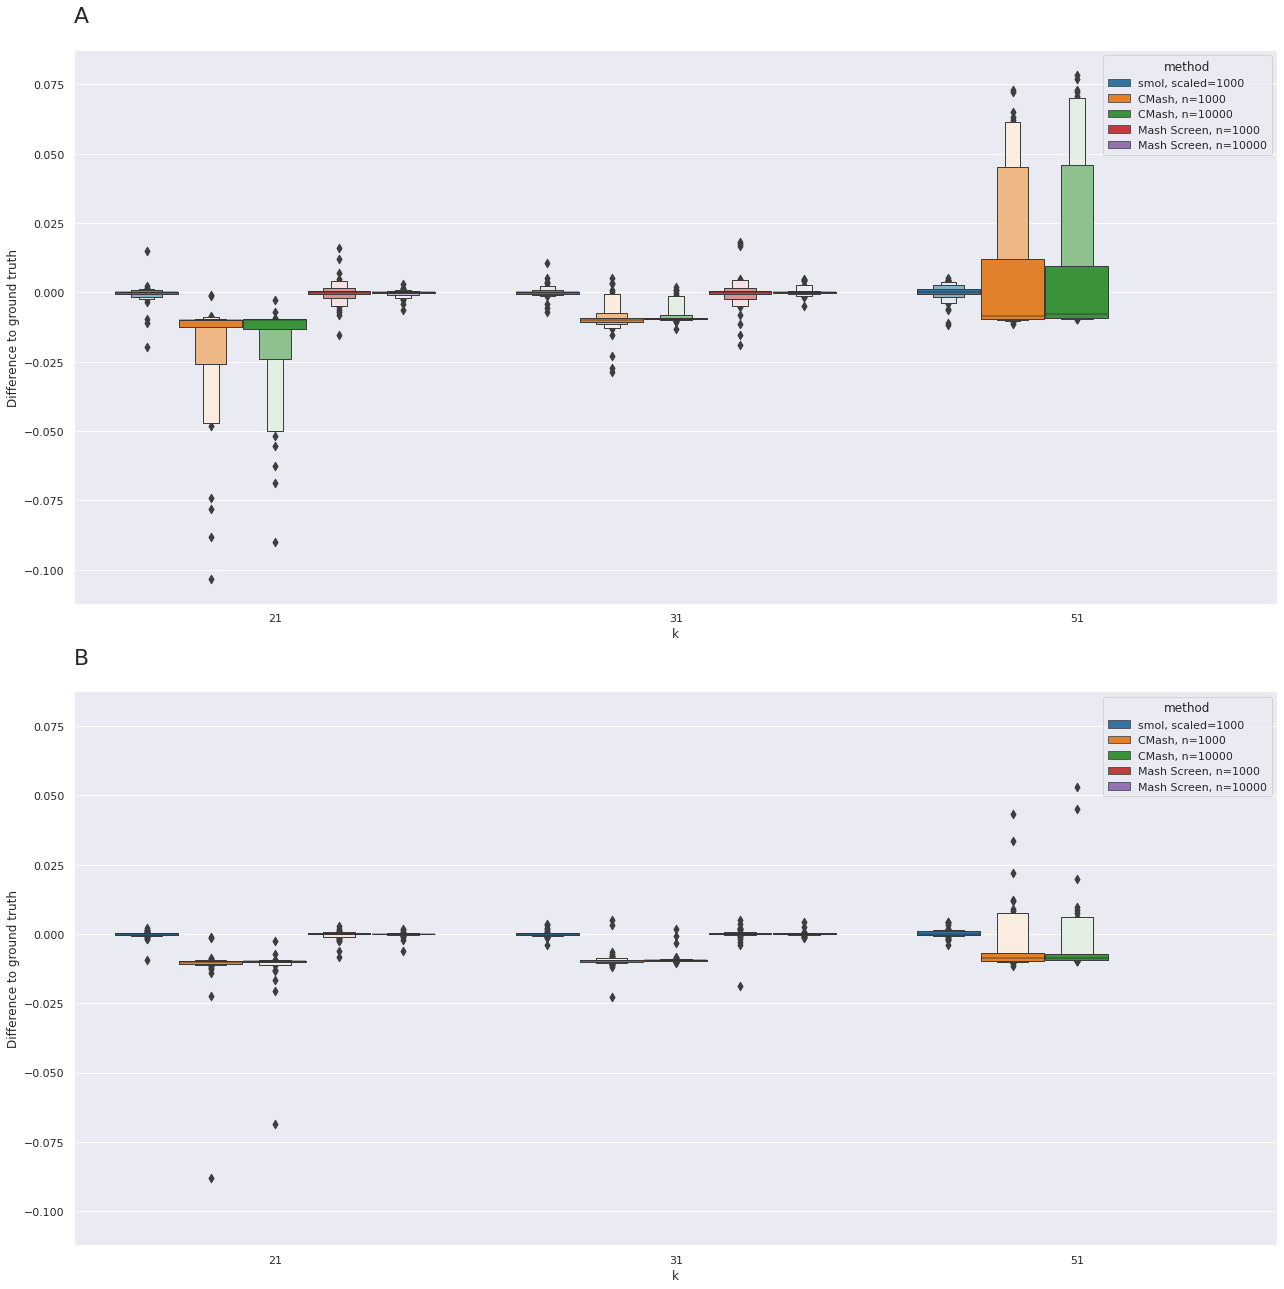

In [123]:
sns.set_palette("tab10", n_colors=5)
with FigureManager(figsize=(18, 18), show=True, filename=f"../figures/containment.pdf", nrows=2, sharey=True) as (fig, ax):
    plot_df = difference_from_exact()
    sns.boxenplot(x="k", y="containment", hue="method", data=plot_df, ax=ax[0])
    ax[0].set_ylabel(f"Difference to ground truth")
    ax[0].text(0, 1.05, "A", transform=ax[0].transAxes, fontsize=22)

    sns.boxenplot(x="k", y="containment", hue="method", data=plot_df.drop([f"{i}.fa" for i in low_coverage]), ax=ax[1])
    ax[1].set_ylabel(f"Difference to ground truth")
    ax[1].text(0, 1.05, "B", transform=ax[1].transAxes, fontsize=22)

    fig.tight_layout()

## Scaled MinHash sizes for reference genomes in Shakya

In [365]:
from pathlib import Path
import json

sizes = {k: {} for k in (21,31,51)}
for k in sizes:
    for sigf in Path("../outputs/smol_1000/refs/").glob(f"*-k{k}.smol"):
        sig = json.loads(sigf.read_bytes())
        sizes[k][sigf.parts[-1].split("-")[0]] = len(sig['hashes'])

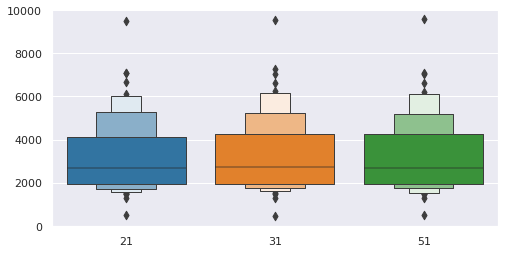

In [366]:
sig_sizes = pd.DataFrame(sizes)
with FigureManager(figsize=(8, 4), show=True) as (fig, ax):
    sns.boxenplot(data=sig_sizes, ax=ax)

In [368]:
sig_sizes.describe().applymap(lambda x: "{:,.0f}".format(x))

,21,31,51
count,68,68,68
mean,"3,213","3,227","3,229"
std,"1,729","1,730","1,731"
min,503,431,489
25%,"1,920","1,918","1,946"
50%,"2,697","2,727","2,682"
75%,"4,136","4,270","4,237"
max,"9,500","9,540","9,611"


In [378]:
sig_sizes.quantile(0.8)

21    4911.0
31    4899.8
51    4973.6
Name: 0.8, dtype: float64

# Extras

## Median abundance (sourmash and mash)

mash also calculates abundance for each hash, so we can compare the median abundance reported by both mash and sourmash.

In [21]:
mash_screen = pd.read_table(
    f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m1.tsv",
    header=None,
    names=(
        "identity",
        "hashes",
        "median abundance mash",
        "p-value",
        "filename",
        "description",
    ),
    usecols=("hashes", "median abundance mash", "filename"),
)
mash_screen["filename"] = mash_screen["filename"].str.replace(".*/", "")
mash_screen["mash"] = mash_screen["hashes"].apply(lambda x: eval(x))
del mash_screen["hashes"]
mash_screen.set_index("filename", inplace=True)

In [22]:
sourmash = pd.read_table(
    f"../outputs/scaled_1000/SRR606249-k{ksize}.csv",
    sep=",",
    usecols=["f_match", "median_abund", "filename"],
)
sourmash.columns = ("sourmash", "median abundance sourmash", "filename")
sourmash["filename"] = sourmash["filename"].str.replace(
    r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa"
)
sourmash.set_index("filename", inplace=True)

Keeping only result where the difference in median abundance is at least 1. Also highlighting differences:
 - <span style="color: RGBA(171, 145, 68, 1)">median abundance difference < 10</span>
 - <span style="color: darkred">median abundance difference < 30</span>
 - large containment differences (>0.05): gradient background
    
**TODO** repeat this with the full containment, not only `f_match`

In [23]:
def highlight_diff(s):
    mdiff = np.abs(s["median abundance mash"] - s["median abundance sourmash"])
    cdiff = np.abs(s["mash"] - s["sourmash"])

    gradient_bg = "background: repeating-linear-gradient(45deg, rgba(0, 0, 0, 0.2), rgba(0, 0, 0, 0.2) 10px, rgba(0, 0, 0, 0.3) 10px, rgba(0, 0, 0, 0.3) 20px);"
    bg = ""
    if cdiff >= 0.05:
        bg = gradient_bg

    if mdiff == 1:
        color = "background-color: white"
    elif mdiff < 10:
        color = "background-color: yellow"
    else:
        color = "background-color: red; color:white"

    return [bg + color] * 4


abundances = pd.concat((mash_screen, sourmash), axis=1)
with pd.option_context("display.max_rows", None, "show_dimensions", True):
    diff = abundances["median abundance mash"] - abundances["median abundance sourmash"]
    display(abundances[diff.abs() >= 1].style.apply(highlight_diff, axis=1))

,median abundance mash,mash,sourmash,median abundance sourmash
0.fa,32,1.000000,0.999520,27.000000
1.fa,29,1.000000,0.998647,26.000000
2.fa,14,1.000000,1.000000,12.000000
3.fa,49,0.999000,0.998133,42.000000
4.fa,9,0.999000,0.997446,8.000000
5.fa,7,0.996000,0.986600,6.000000
6.fa,6,0.951000,0.934101,5.000000
7.fa,4,0.936000,0.905975,3.000000
8.fa,19,0.999000,0.948924,16.000000
9.fa,14,1.000000,0.997486,12.000000


## Interactive similarity plot

In [24]:
data = np.load(f"../outputs/scaled_1000/similarity-k{ksize}")
with open(f"../outputs/scaled_1000/similarity-k{ksize}.labels.txt", "r") as f:
    labels = f.readlines()

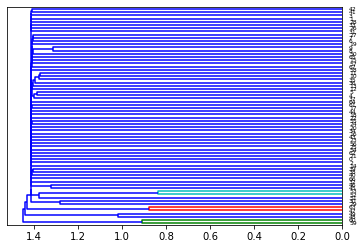

In [25]:
import scipy.cluster.hierarchy as sch

Y = sch.linkage(data, method="single")  # centroid
dendrolabels = [str(i) for i in range(len(labels))]
# dendrolabels = labels
Z1 = sch.dendrogram(Y, orientation="left", labels=dendrolabels, no_labels=False)

idx1 = Z1["leaves"]
data = data[idx1, :]
data = data[:, idx1]

In [26]:
df = pd.DataFrame(data, index=labels, columns=labels)
df.hvplot.heatmap(width=800, height=600, colormap="YlGnBu", xaxis=None, yaxis=None)

:HeatMap   [columns,index]   (value)

## CMash with TST (new version)

CMash outputs the filename and one column per k-size with the containment to each match.
I built an index with `k=51` and queried with ranges `21-51-10` (ksizes `21,31,41,51`):

In [27]:
cmash_all = pd.read_table("../outputs/cmash/SRR606249.csv", sep=",")
cmash_all.columns = ["filename"] + [c for c in cmash_all.columns[1:]]
cmash_all.set_index("filename", inplace=True)
columns = [c for c in cmash_all.columns if str(ksize) not in c]
cmash_all.drop(columns=columns, inplace=True)
cmash_all.columns = ["cmash all "] + cmash_all.columns


But... It seems the results are different than building one DB for each ksize, and querying only that ksize. In some cases, it's more than a 40% difference...

According to https://github.com/dkoslicki/CMash/issues/15#issuecomment-608057130, for now I should stick with:
> should only be used when the training database is constructed with a k-mer size of K and the StreamingQueryDNADatabase.py is called with the k-range of `K-K-1`.

which is the case for this this one:

In [28]:
cmash = pd.read_table(f"../outputs/cmash/SRR606249-k{ksize}-n{num}.csv", sep=",")
cmash.columns = ["filename"] + [c for c in cmash.columns[1:]]
cmash.set_index("filename", inplace=True)
columns = [c for c in cmash.columns if str(ksize) not in c]
cmash.drop(columns=columns, inplace=True)
cmash.columns = ["cmash "] + cmash.columns

In [29]:
cmash_diff = np.abs(cmash_all[f"cmash all k={ksize}"] - cmash[f"cmash k={ksize}"])
cmash_diff[cmash_diff > 0.01].sort_values()

filename
47.fa    0.010000
39.fa    0.010000
13.fa    0.011000
21.fa    0.011000
14.fa    0.013000
30.fa    0.013000
40.fa    0.014000
18.fa    0.016000
2.fa     0.016000
46.fa    0.017000
45.fa    0.017000
27.fa    0.018000
63.fa    0.023000
64.fa    0.028000
7.fa     0.032000
44.fa    0.035000
55.fa    0.041000
23.fa    0.058000
67.fa    0.065000
4.fa     0.073000
5.fa     0.073000
3.fa     0.090000
25.fa    0.095000
66.fa    0.117000
20.fa    0.121000
35.fa    0.139325
19.fa    0.144000
33.fa    0.151000
31.fa    0.164000
58.fa    0.230000
51.fa    0.233000
6.fa     0.250000
17.fa    0.272000
32.fa    0.281000
49.fa    0.383000
16.fa    0.510000
dtype: float64

In [30]:
def highlight_diff_from_cmash_paper(s):
    diff = np.abs(s - s["cmash paper"])
    colorized = []
    for v in diff:
        if v < 0.01:
            colorized.append("background-color: white")
        elif v < 0.05:
            colorized.append("background-color: yellow")
        elif v < 0.10:
            colorized.append("background-color: orange")
        else:
            colorized.append("background-color: red")
    return colorized


with pd.option_context("display.max_rows", None, "show_dimensions", True):
    df = pd.concat((cmash_paper, cmash_all, cmash), axis=1).sort_values(by=f"cmash k={ksize}")
    df = df[df.apply(lambda x: any(np.abs(x - x["cmash paper"]) > 0.01), axis=1)]
    display(df.style.apply(highlight_diff_from_cmash_paper, axis=1))

,cmash paper,cmash all k=21,cmash k=21
64.fa,0.015000,0.044000,0.016000
66.fa,0.181000,0.298000,0.181000
67.fa,0.198000,0.266000,0.201000
20.fa,0.229000,0.350000,0.229000
6.fa,0.945000,0.718000,0.468000
16.fa,0.962000,0.988000,0.478000
23.fa,0.982000,0.576000,0.518000
49.fa,0.983000,0.926000,0.543000
19.fa,0.630000,0.778000,0.634000
17.fa,0.819000,0.910000,0.638000


## Difference to exact (4-plots version)

In [304]:
def data_for_num(num):
    all_methods = []
    for k in (21, 31, 51):
        exact = pd.read_table(
            f"../outputs/exact/SRR606249-k{k}.csv",
            sep=",",
            header=None,
            names=("filename", "containment", "intersection", "|A|"),
            usecols=("filename", "containment"),
        )
        exact["filename"] = exact["filename"].str.replace(
            r".*/(?P<id>\d+)-k\d+.set", lambda m: m.group("id") + ".fa"
        )
        exact.set_index("filename", inplace=True)    
        #all_methods.append(exact)

        smol = pd.read_table(
            f"../outputs/smol_{scaled}/search-SRR606249-k{k}.csv",
            sep=",",
            header=None,
            names=("filename", "containment"),
            usecols=("filename", "containment"),
        )
        smol["filename"] = smol["filename"].str.replace(
            r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
        )
        smol.set_index("filename", inplace=True)
        smol['containment'] = exact["containment"] - smol['containment']
        smol['method'] = 'smol'
        smol['k'] = k

        all_methods.append(smol)

        cmash_paper = pd.read_table(
            f"../outputs/cmash_paper/SRR606249-k{ksize}-n{num}.csv",
            sep=",",
            header=0,
            names=("filename", "intersection", "containment", "jaccard index"),
            usecols=("filename", "containment"),
        )
        cmash_paper.columns = ["filename"] + [c for c in cmash_paper.columns[1:]]
        cmash_paper["filename"] = cmash_paper["filename"].str.replace(
            r".*/(?P<id>\d+).fa.*", lambda m: m.group("id") + ".fa"
        )
        cmash_paper.set_index("filename", inplace=True)   
        cmash_paper['containment'] = exact["containment"] - cmash_paper['containment']
        cmash_paper['method'] = 'cmash'
        cmash_paper['k'] = k

        all_methods.append(cmash_paper)

        if k <= 32:  # mash doesn't support k>32
            mash_m1 = pd.read_table(
                f"../outputs/mash_screen/SRR606249-k{k}-s{num}-m1.tsv",
                header=None,
                names=(
                    "identity",
                    "hashes",
                    "median abundance",
                    "p-value",
                    "filename",
                    "description",
                ),
                usecols=["filename", "hashes"],
            )
            mash_m1["filename"] = mash_m1["filename"].str.replace(".*/", "")
            mash_m1["containment"] = mash_m1["hashes"].apply(lambda x: eval(x))
            del mash_m1["hashes"]
            mash_m1.set_index("filename", inplace=True)    
            mash_m1['containment'] = exact["containment"] - mash_m1['containment']
            mash_m1['method'] = 'mash'
            mash_m1['k'] = k

            all_methods.append(mash_m1)

    return pd.concat(all_methods)

In [305]:
def plot_for_num(num):
    plot_df = data_for_num(num)

    with FigureManager(figsize=(18, 12), show=True, filename=f"../figures/containment_{num}.pdf", ncols=2, sharey=True) as (fig, ax):
        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df, ax=ax[0])
        ax[0].set_ylabel(f"Difference to ground truth")
        ax[0].set_title(f"Difference in estimates, all genomes")
        ax[0].text(0.5, 1.05, "A", transform=ax[0].transAxes, fontsize=22)

        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df.drop([f"{i}.fa" for i in low_coverage]), ax=ax[1])
        ax[1].set_ylabel(f"")    
        ax[1].set_title(f"Difference in estimates, excluding low coverage genomes")
        ax[1].text(0.5, 1.05, "B", transform=ax[1].transAxes, fontsize=22)        
        
        fig.tight_layout()

In [361]:
def plot_4():
    with FigureManager(figsize=(18, 18), show=True, filename=f"../figures/containment-4.pdf", ncols=2, nrows=2, sharey=True) as (fig, ax):
        plot_df = data_for_num(1000)
        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df, ax=ax[0,0])
        ax[0,0].set_ylabel(f"Difference to ground truth")
        ax[0,0].set_title(f"n=1000, scaled=1000")
        ax[0,0].text(0.5, 1.05, "A", transform=ax[0,0].transAxes, fontsize=22)

        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df.drop([f"{i}.fa" for i in low_coverage]), ax=ax[0,1])
        ax[0,1].set_ylabel(f"")    
        ax[0,1].set_title(f"n=1000, scaled=1000, excluding low coverage genomes")
        ax[0,1].text(0.5, 1.05, "B", transform=ax[0,1].transAxes, fontsize=22)        

        plot_df = data_for_num(10000)
        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df, ax=ax[1,0])
        ax[1,0].set_ylabel(f"Difference to ground truth")
        ax[1,0].set_title(f"n=10000, scaled=1000")
        ax[1,0].text(0.5, 1.05, "C", transform=ax[1,0].transAxes, fontsize=22)

        sns.boxenplot(x="k", y="containment", hue="method", data=plot_df.drop([f"{i}.fa" for i in low_coverage]), ax=ax[1,1])
        ax[1,1].set_ylabel(f"")    
        ax[1,1].set_title(f"n=10000, scaled=1000, excluding low coverage genomes")
        ax[1,1].text(0.5, 1.05, "D", transform=ax[1,1].transAxes, fontsize=22) 

    fig.tight_layout()